In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from IPython.display import Image
%matplotlib inline

In [2]:
# 0 -- > nao urbana
# 1 ---> urbana

SEED = 50
CARTA = 'SC-24-Z-C'

In [3]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [5]:
#get dataset
# dataset = pd.read_csv("../dataset/dataset-temp.csv")
dataset = pd.read_csv("../dataset/dataset_" + CARTA + "_1994.csv")
df = dataset.copy()

In [6]:
labels = np.array(df.pop('value'))
df = df.drop(columns = ['code', 'maingrid', 'randomc', 'OGC_FID', 
                        'subgrid'])

In [7]:
dataset[dataset['value']==1].describe()

red        green         blue          nir        swir1  \
count  1168.000000  1168.000000  1168.000000  1168.000000  1168.000000   
mean   1274.113870  1119.327483   722.548801  2936.309075  2883.960616   
std     400.030075   277.037202   203.274791   444.303741   655.701670   
min     376.000000   494.500000   253.000000  1414.000000   793.000000   
25%     979.000000   926.875000   583.750000  2648.875000  2452.750000   
50%    1258.000000  1095.000000   706.000000  2946.500000  2838.000000   
75%    1534.625000  1288.125000   844.000000  3230.625000  3273.625000   
max    2545.000000  2175.000000  1625.000000  4466.000000  5618.500000   

             swir2      randomc   value        OGC_FID  
count  1168.000000  1168.000000  1168.0    1168.000000  
mean   2004.856164     0.499070     1.0  167395.598459  
std     653.467207     0.290764     0.0   88134.817169  
min     433.500000     0.000289     1.0   56450.000000  
25%    1536.000000     0.248320     1.0  108365.750000  
50%    1948.750000     0.501801     1.0  125750.500000  
75%    2432.625000     0.748266     1.0  271958.250000  
max    4440.000000     0.998533     1.0  298140.000000

In [8]:
dataset[dataset['value']==0].describe()

red        green         blue          nir        swir1  \
count  1215.000000  1215.000000  1215.000000  1215.000000  1215.000000   
mean    852.749794   839.552263   535.585185  2932.369959  2527.778189   
std     408.853528   284.387285   198.048029   583.263123   869.227001   
min     225.000000   294.000000   167.000000   167.000000    54.000000   
25%     574.750000   650.750000   405.250000  2598.500000  1955.500000   
50%     753.000000   788.000000   502.000000  2933.000000  2445.000000   
75%    1050.250000   976.250000   635.250000  3281.250000  3030.500000   
max    3717.000000  3190.000000  2042.000000  4978.000000  5772.000000   

             swir2      randomc   value        OGC_FID  
count  1215.000000  1215.000000  1215.0    1215.000000  
mean   1443.709053     0.515791     0.0  251226.102881  
std     758.812494     0.282152     0.0  109154.220143  
min      76.000000     0.002023     0.0    8274.000000  
25%     904.250000     0.290019     0.0  297832.500000  
50%    1295.000000     0.517181     0.0  298136.000000  
75%    1835.500000     0.755902     0.0  306039.500000  
max    4973.000000     0.998831     0.0  306343.000000

In [9]:
dir(df)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',

In [10]:
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = SEED)

In [11]:
print(train.shape)
print(test.shape)

(1668, 6)
(715, 6)


In [12]:
features = list(train.columns)

In [13]:


# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 442
Average maximum depth 16


In [15]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

Recall Baseline: 1.0 Test: 0.78 Train: 1.0
Precision Baseline: 0.49 Test: 0.82 Train: 1.0
Roc Baseline: 0.5 Test: 0.89 Train: 1.0


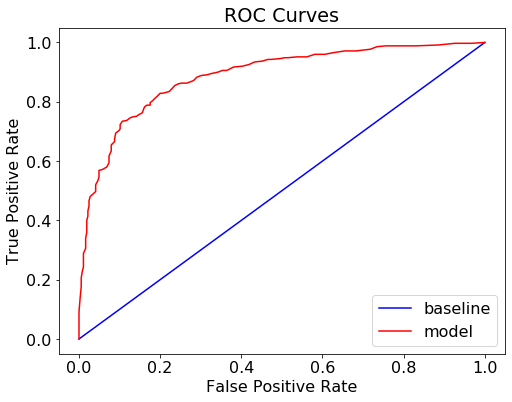

In [16]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[306  59]
 [ 76 274]]


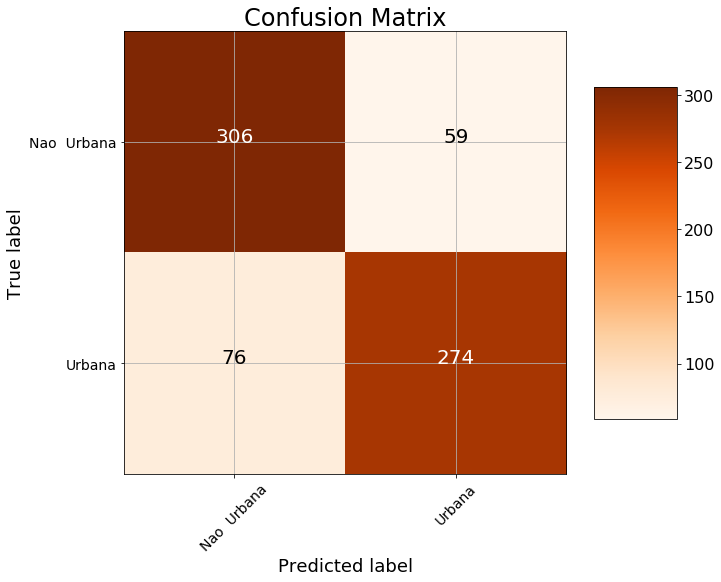

In [17]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Nao  Urbana', 'Urbana'],
                      title = 'Confusion Matrix')

In [18]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

feature  importance
0     red    0.247897
4   swir1    0.209128
1   green    0.174166
5   swir2    0.138012
2    blue    0.120181
3     nir    0.110617

In [19]:

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=SEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [20]:
rs.best_params_

{'n_estimators': 188,
 'min_samples_split': 2,
 'max_leaf_nodes': 33,
 'max_features': 0.7999999999999999,
 'max_depth': 12,
 'bootstrap': True}

In [21]:
best_model = rs.best_estimator_

In [22]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [23]:

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 65
Average maximum depth 8


Recall Baseline: 1.0 Test: 0.77 Train: 0.86
Precision Baseline: 0.49 Test: 0.83 Train: 0.89
Roc Baseline: 0.5 Test: 0.88 Train: 0.95


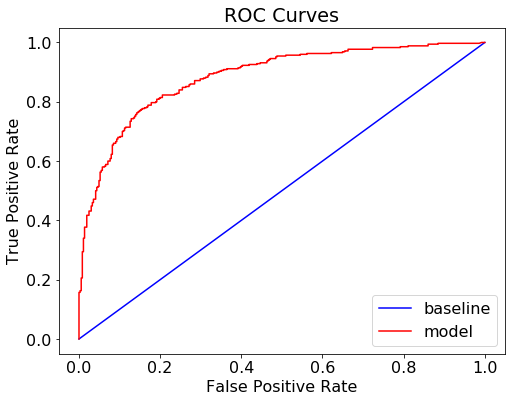

In [24]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [25]:
estimator = best_model.estimators_[0]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

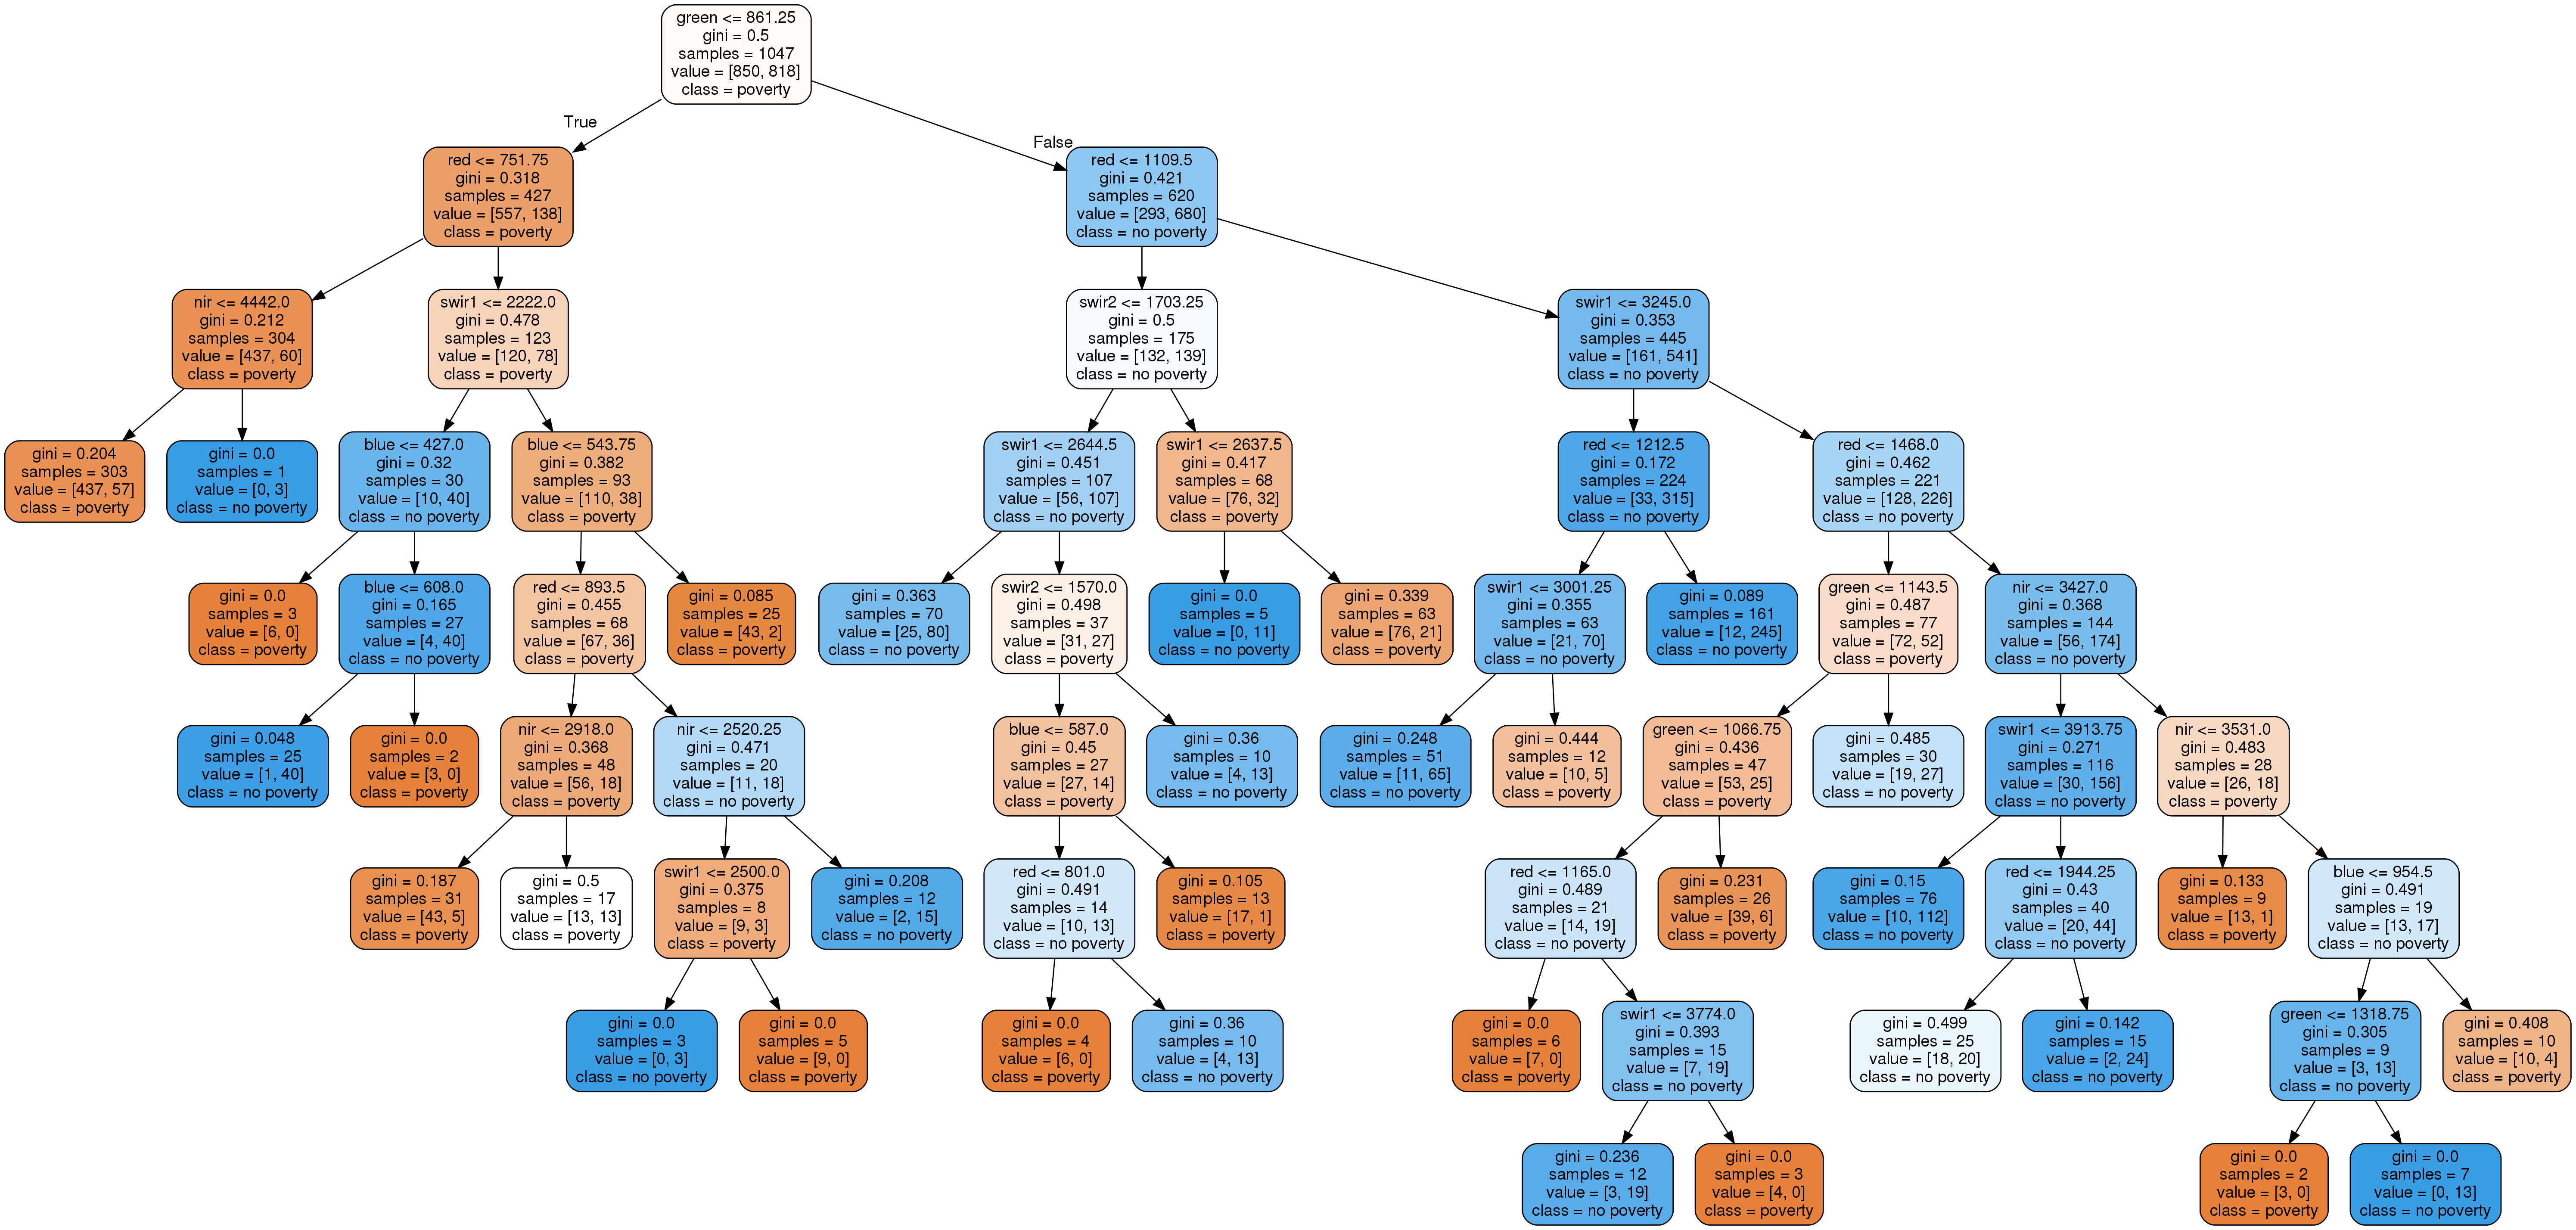

In [26]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

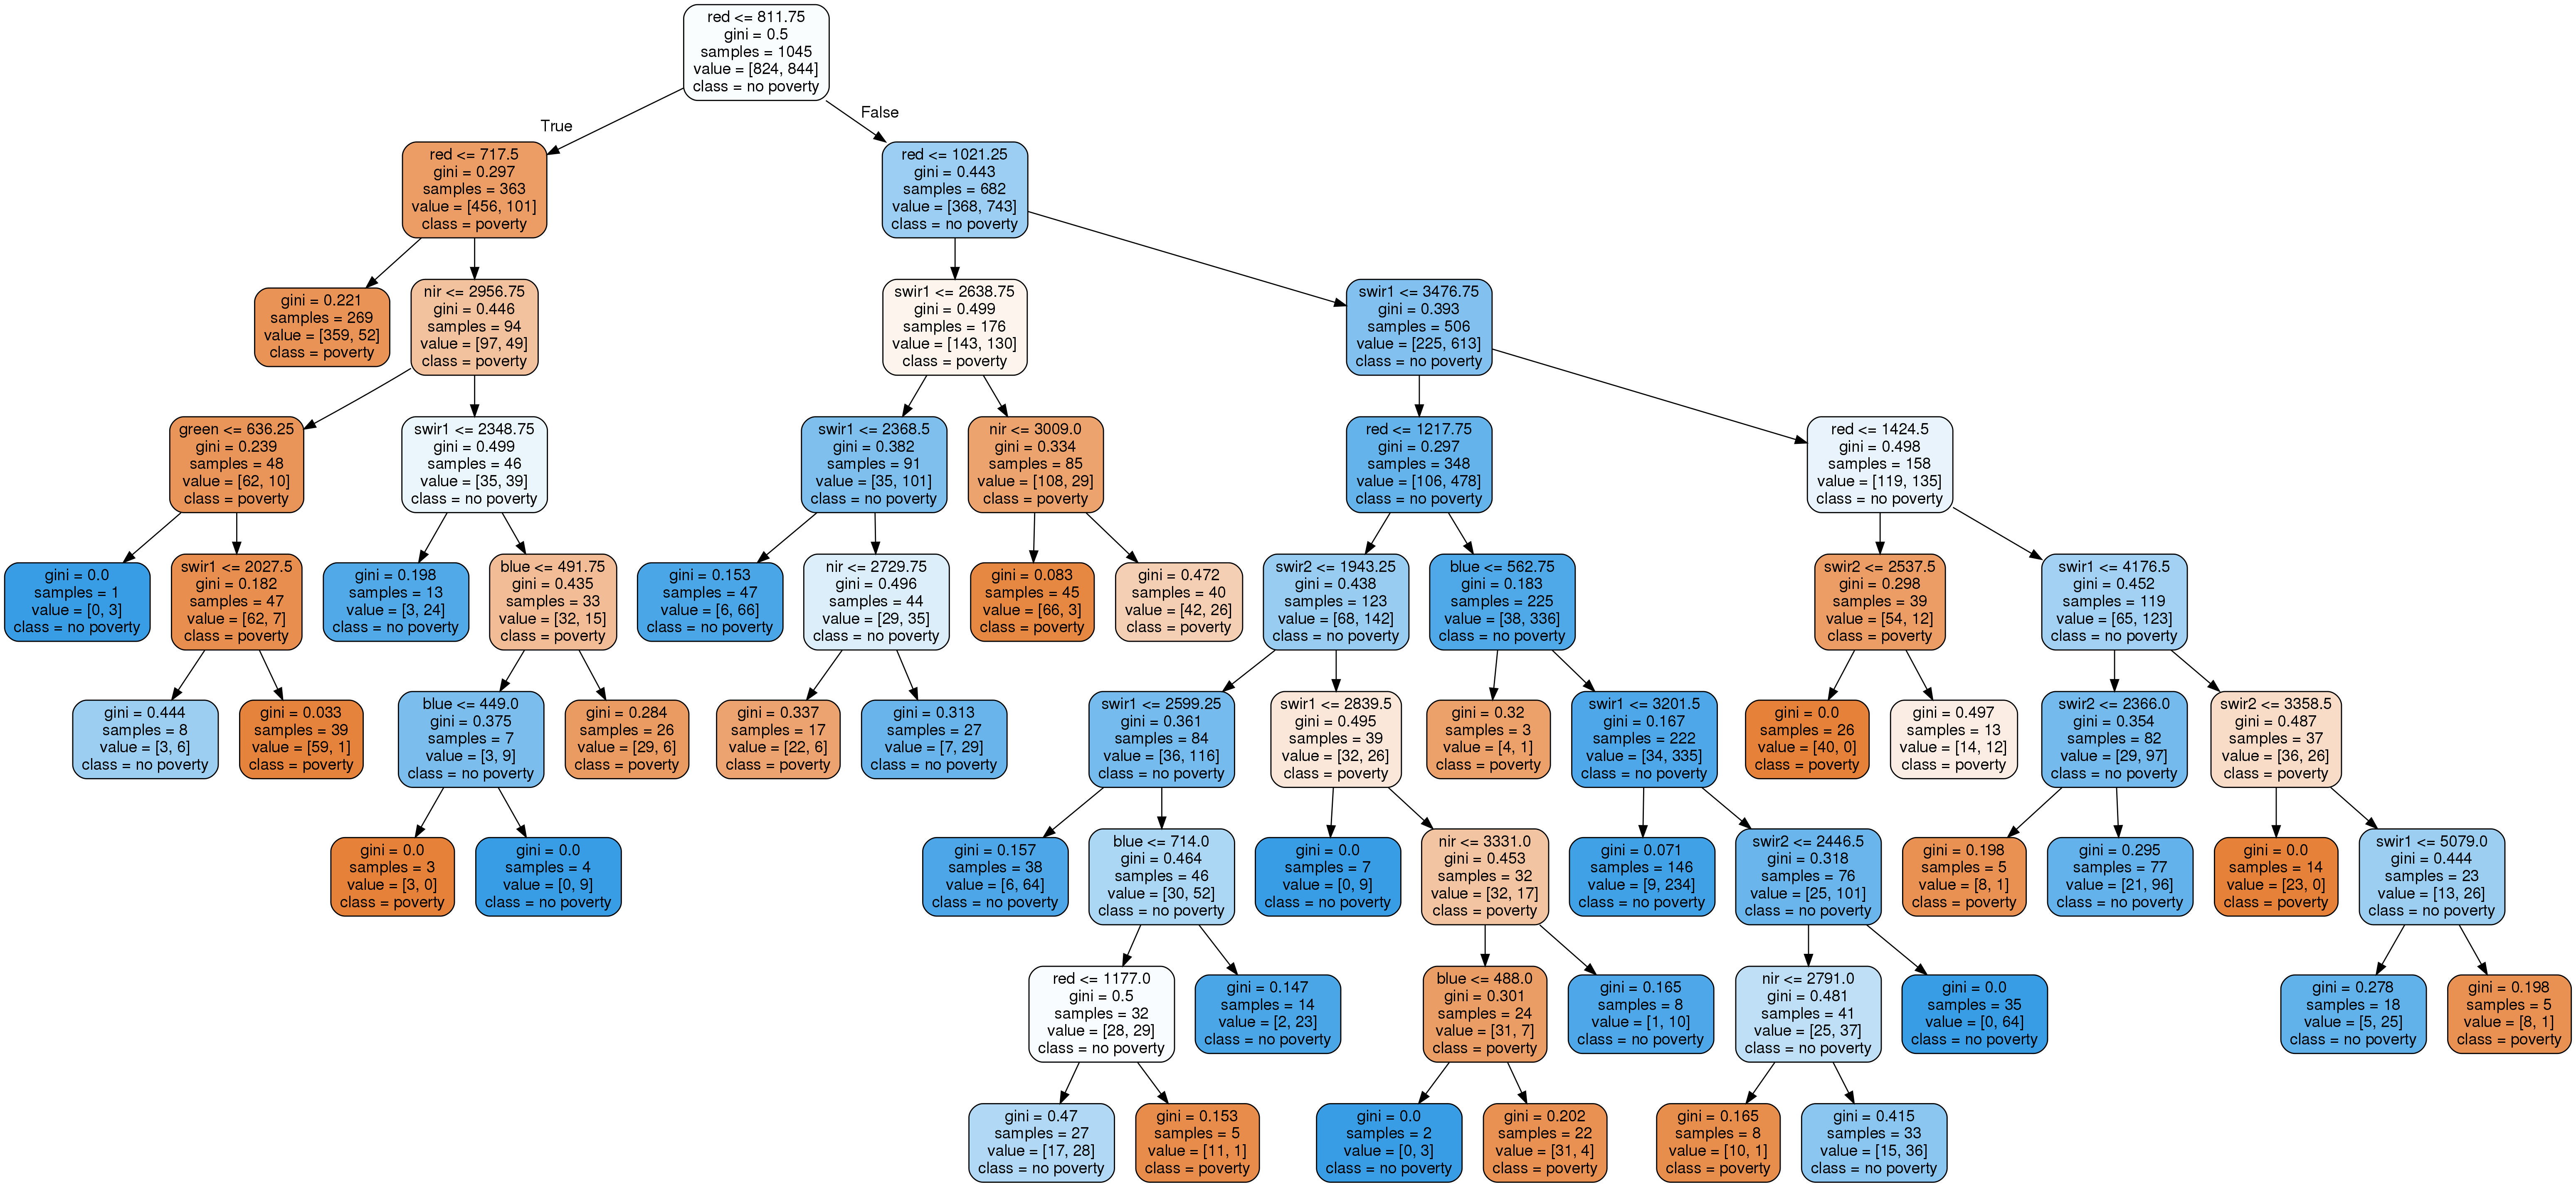

In [27]:
estimator = best_model.estimators_[80]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

In [28]:
estimator.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=0.7999999999999999, max_leaf_nodes=33,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=783218067, splitter='best')>

In [29]:
len(best_model.estimators_)

188